In [1]:
import pipeline

from sklearn.metrics import *

import pandas as pd
import numpy as np
from pipeline import analyze_best_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# setup 
df = pd.read_csv('data/final_merged_df.csv')
splits = pipeline.split_all_years(df, colname='year_evictions')
cleaned_splits = [pipeline.clean_split(split) for split in splits]
labeled_splits = [pipeline.label(split, lower_bound=14, drop_column=True)
                  for split in cleaned_splits]

In [3]:
# best classifier   
train_df, test_df = labeled_splits[-1]
params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}
model, scored_df = pipeline.run_one_clf(train_df, test_df, 'GB', params, col_blacklist=['GEOID', 'year_evictions'])

0.1377245508982036
0.1377245508982036
0.1377245508982036
1.0


<Figure size 432x288 with 0 Axes>

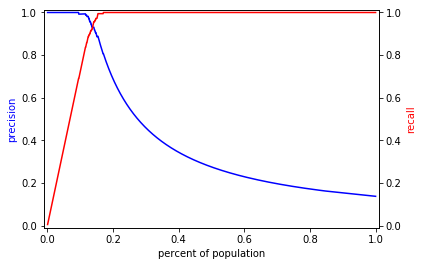

In [4]:
# precision-recall curve 
print(test_df['label'].mean())
print(scored_df['label'].mean())
pipeline.plot_precision_recall_n(scored_df)

In [5]:
# top k% blocks 
k = 0.16
num_blocks = int(scored_df.shape[0]*k)//1
clf_blocks = scored_df.nlargest(num_blocks, ['score'])[['GEOID', 'score', 'label']]

In [6]:
# feature importance 
all_vars = list(test_df.columns)
features = [v for v in all_vars if v not in ('GEOID', 'year_evictions', 'evictions', 'label')]
feature_importance = pd.DataFrame(zip(features, model.feature_importances_),
                                      columns=['feature', 'importance'])
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.round(2).head(10)

,feature,importance
67,evictions_t-1_scaled,0.40
68,evictions_t-2_scaled,0.19
3,evictions_change_1,0.13
4,evictions_change_2,0.08
69,evictions_t-5_scaled,0.07
5,evictions_change_5,0.05
21,evictions_change_1_binary,0.01
76,median_gross_rent_scaled,0.01
77,median_household_income_scaled,0.00
10,for_rent_units_percent,0.00


In [7]:
# best regressor 
train_df, test_df = cleaned_splits[-1]
params = {'max_depth': 50, 'max_features': None, 'min_samples_split': 10}
model, scored_df = pipeline.run_one_reg(train_df, test_df, 'DTR', params, col_blacklist=['GEOID', 'year_evictions'])

In [8]:
# top k% blocks 
k = 0.16
num_blocks = int(scored_df.shape[0]*k)//1
reg_blocks = scored_df.nlargest(num_blocks, ['pred_evictions'])[['GEOID', 'pred_evictions', 'evictions']]

In [9]:
# feature importance 
all_vars = list(test_df.columns)
features = [v for v in all_vars if v not in ('GEOID', 'year_evictions', 'evictions', 'label')]
feature_importance = pd.DataFrame(zip(features, model.feature_importances_),
                                      columns=['feature', 'coef'])
feature_importance.sort_values(by='coef', ascending=False, inplace=True)
feature_importance.round(2).head(10)

,feature,coef
67,evictions_t-1_scaled,0.72
3,evictions_change_1,0.21
21,evictions_change_1_binary,0.04
68,evictions_t-2_scaled,0.02
5,evictions_change_5,0.00
23,evictions_change_5_binary,0.00
69,evictions_t-5_scaled,0.00
9,vacant_units_percent,0.00
4,evictions_change_2,0.00
22,evictions_change_2_binary,0.00


In [10]:
# selected block groups
clf_blocks.rename(columns={'GEOID': 'GEOID_clf'}, inplace=True)
reg_blocks.rename(columns={'GEOID': 'GEOID_reg'}, inplace=True)
merged_df = pd.merge(clf_blocks, reg_blocks, left_on='GEOID_clf', right_on='GEOID_reg', how='outer')
merged_df.sort_values(by='evictions', ascending=False)

,GEOID_clf,score,label,GEOID_reg,pred_evictions,evictions
37,4.210103e+11,0.688532,1.0,4.210103e+11,75.500000,128.0
63,4.210103e+11,0.668608,1.0,4.210103e+11,69.333333,83.0
78,4.210104e+11,0.649766,1.0,4.210104e+11,51.666667,78.0
11,4.210102e+11,0.703588,1.0,4.210102e+11,53.375000,58.0
14,4.210103e+11,0.702355,1.0,4.210103e+11,54.333333,58.0
12,4.210103e+11,0.702963,1.0,4.210103e+11,53.375000,58.0
60,4.210103e+11,0.673540,1.0,4.210103e+11,53.375000,51.0
21,4.210102e+11,0.696610,1.0,4.210102e+11,51.666667,50.0
68,4.210104e+11,0.664359,1.0,4.210104e+11,44.428571,49.0
43,4.210103e+11,0.684783,1.0,4.210103e+11,38.571429,47.0
